In [2]:
import  pandas as pd
#open file bnpl
df = pd.read_csv('bnpl.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      1000 non-null   object 
 1   failed_traditional_credit       1000 non-null   int64  
 2   bnpl_usage_frequency            1000 non-null   int64  
 3   over_indebtedness_flag          1000 non-null   int64  
 4   financial_stress_score          1000 non-null   int64  
 5   external_repayment_loans        1000 non-null   int64  
 6   credit_card_interest_incidence  1000 non-null   int64  
 7   credit_limit_utilisation        1000 non-null   int64  
 8   payment_delinquency_count       1000 non-null   int64  
 9   impulsive_buying_score          1000 non-null   int64  
 10  financial_literacy_assessment   1000 non-null   int64  
 11  debt_accumulation_metric        1000 non-null   float64
 12  return_dispute_incidents        100

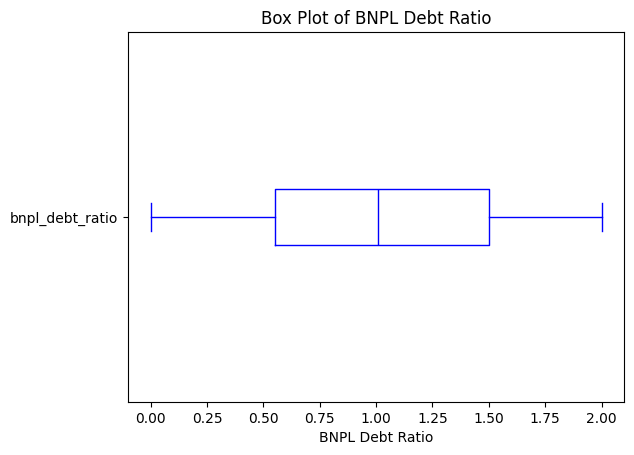

In [4]:
#create a box plot for debt to ratio column
df.boxplot(column='bnpl_debt_ratio', grid=False, color='blue', vert=False)
#show the plot
import matplotlib.pyplot as plt
plt.title('Box Plot of BNPL Debt Ratio')
plt.xlabel('BNPL Debt Ratio')
plt.show()

In [5]:
# Function to find outliers using IQR method
def find_iqr_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return series[(series < lower) | (series > upper)]

# Example for bnpl_debt_ratio:
outliers = find_iqr_outliers(df['bnpl_usage_frequency'])
print("Outliers:\n", outliers)


Outliers:
 Series([], Name: bnpl_usage_frequency, dtype: int64)


In [6]:
default_flag = (
    (df['payment_delinquency_count'] >= 3).astype(int) +
    (df['over_indebtedness_flag'] == 1).astype(int) +
    (df['financial_stress_score'] >= 9).astype(int) +
    (df['bnpl_debt_ratio'] >= 1.8).astype(int) +
    (df['credit_limit_utilisation'] >= 95).astype(int)
) >= 3  # Must meet at least 3 of the 5 conditions
print("Default Flag (at least 3 conditions):\n", default_flag)
# print the mean of the default_flag
print("Mean of Default Flag (at least 3 conditions):", default_flag.mean())

Default Flag (at least 3 conditions):
 0      False
1       True
2      False
3      False
4      False
       ...  
995    False
996    False
997    False
998    False
999    False
Length: 1000, dtype: bool
Mean of Default Flag (at least 3 conditions): 0.085


In [7]:
#save the df as a csv file
df['default_flag'] = default_flag.astype(int)
df.to_csv('bnpl_with_default_flag.csv', index=False)


In [8]:
#check for outliers in each column
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    outliers = find_iqr_outliers(df[column])
    print(f"Outliers in {column}:\n", outliers)


Outliers in failed_traditional_credit:
 Series([], Name: failed_traditional_credit, dtype: int64)
Outliers in bnpl_usage_frequency:
 Series([], Name: bnpl_usage_frequency, dtype: int64)
Outliers in over_indebtedness_flag:
 Series([], Name: over_indebtedness_flag, dtype: int64)
Outliers in financial_stress_score:
 Series([], Name: financial_stress_score, dtype: int64)
Outliers in external_repayment_loans:
 Series([], Name: external_repayment_loans, dtype: int64)
Outliers in credit_card_interest_incidence:
 Series([], Name: credit_card_interest_incidence, dtype: int64)
Outliers in credit_limit_utilisation:
 Series([], Name: credit_limit_utilisation, dtype: int64)
Outliers in payment_delinquency_count:
 Series([], Name: payment_delinquency_count, dtype: int64)
Outliers in impulsive_buying_score:
 Series([], Name: impulsive_buying_score, dtype: int64)
Outliers in financial_literacy_assessment:
 Series([], Name: financial_literacy_assessment, dtype: int64)
Outliers in debt_accumulation_metr

In [10]:
#drop customer_id column
df = df.drop(columns=['CustomerID'])
df

,failed_traditional_credit,bnpl_usage_frequency,over_indebtedness_flag,financial_stress_score,external_repayment_loans,credit_card_interest_incidence,credit_limit_utilisation,payment_delinquency_count,impulsive_buying_score,financial_literacy_assessment,debt_accumulation_metric,return_dispute_incidents,demographic_risk_factor,bnpl_debt_ratio,default_flag
0,0,15,1,8,0,0,48,2,9,8,1.61,2,3,0.03,0
1,1,12,1,10,1,0,13,5,6,1,2.20,3,2,0.31,1
2,1,14,1,4,0,0,39,5,3,6,4.17,3,4,0.84,0
3,0,8,0,2,0,0,39,4,6,2,4.65,3,5,0.14,0
4,0,3,0,2,1,0,31,2,10,2,3.14,1,1,1.02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,11,1,7,0,0,73,2,7,6,3.42,2,3,1.71,0
996,1,13,1,5,1,0,31,0,5,7,1.80,0,2,0.57,0
997,0,15,1,5,0,0,27,1,2,10,3.34,2,5,0.37,0
998,1,12,1,1,1,1,21,1,2,1,0.20,0,3,0.76,0
